# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Question 2: How much memory does the graphics card have?

Question 3: What is stored in the GPU memory while training a DNN ?

#### **<span style="color:green">Answer:</span>**

- Question 1: 10 496 cores.
- Question 2: 24 GB.
- Question 3: While training a DNN the GPU memory stores the weights of the model. 

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [1]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np
from collections import Counter

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
class_counts = Counter(Y)
for class_label, count in class_counts.items():
    print(f'Class {class_label}: {count} examples')
    

The covariates have size (764137, 92).
The labels have size (764137,).
Class 0.0: 121621 examples
Class 1.0: 642516 examples


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [2]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

# Print the number of NaNs (not a number) in the labels
nan_labels_count = np.isnan(Y).sum()
print(f'The number of NaNs in the labels: {nan_labels_count}')

# Print the number of NaNs in the covariates
nan_covariates_count = np.isnan(X).sum()
print(f'The number of NaNs in the covariates: {nan_covariates_count}')


The number of NaNs in the labels: 0
The number of NaNs in the covariates: 0


#### **<span style="color:green">Answer:</span>**

**Question 4** 

* A Naive classification would in our case guess class 1. Which will give a classification accuracy 642516 / (642516 + 121621) = 0.84

* With random chance we should be able to correctly classify 50% of each class for binary classes. If we have n classes we would be able to classify 1/n of each class. 

# Part 6: Preprocessing

Lets do some simple preprocessing

In [3]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
X_mean = np.mean(X, axis=0)
X -= X_mean.reshape(1, -1)

# Divide each covariate (column) by its standard deviation
X_std = np.std(X, axis=0)
X /= X_std.reshape(1, -1)


# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print("Mean of each covariate after preprocessing:")
print(np.mean(X, axis=0))
print("\nStandard deviation of each covariate after preprocessing:")
print(np.std(X, axis=0))


Mean of each covariate after preprocessing:
[-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [4]:
#!"C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\python.exe" -m pip install scikit-learn
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state=13)



print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
# Training
train_class_counts = Counter(Ytrain)
print("\nNumber of examples of each class in the training data:")
for class_label, count in train_class_counts.items():
    print(f'Class {class_label}: {count} examples')
    
    
# Test & Validation
temp_class_counts = Counter(Ytemp)
print("\nNumber of examples of each class in the remaining 30% data:")
for class_label, count in temp_class_counts.items():
    print(f'Class {class_label}: {count} examples')


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).

Number of examples of each class in the training data:
Class 1: 449824 examples
Class 0: 85071 examples

Number of examples of each class in the remaining 30% data:
Class 1: 192692 examples
Class 0: 36550 examples


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [5]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=13)

print('We get: \nX-validation:{}, \nY-validation:{}, \nX-test:{}, \nY-test:{}'.format(Xval.shape, Yval.shape, Xtest.shape, Ytest.shape))

We get: 
X-validation:(114621, 92), 
Y-validation:(114621,), 
X-test:(114621, 92), 
Y-test:(114621,)


#### **<span style="color:green">Answer:</span>**
It is expected that training-, validation-, and test data have 92 features.
We also expect that 70% of the total number of observations is in train data and 15% for validation and 15% for test data.

# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [63]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from keras.losses import BinaryCrossentropy as BC

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    #if optimizer == 'sgd':
    #    optimizer = SGD(learning_rate=learning_rate)
    #else:
    #    raise ValueError("Optimizer not recognized")
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_dim=input_shape))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss=BC(), optimizer=SGD(learning_rate=learning_rate), metrics=['accuracy'])
    
    return model

In [20]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [64]:
# Setup some training parameters
batch_size = 10000
epochs = 20

# Number of features = 92
input_shape = 92
n_layers = 2
n_nodes = 20

# Build the model
model1 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), batch_size = batch_size, epochs = epochs)

Epoch 1/20
54/54 [==============================] - 1s 9ms/step - loss: 0.6523 - accuracy: 0.6166 - val_loss: 0.5066 - val_accuracy: 0.8406
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4616 - accuracy: 0.8410 - val_loss: 0.4327 - val_accuracy: 0.8406
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4197 - accuracy: 0.8410 - val_loss: 0.4106 - val_accuracy: 0.8406
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4042 - accuracy: 0.8410 - val_loss: 0.3997 - val_accuracy: 0.8406
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3952 - accuracy: 0.8410 - val_loss: 0.3919 - val_accuracy: 0.8406
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3879 - accuracy: 0.8410 - val_loss: 0.3850 - val_accuracy: 0.8406
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3811 - accuracy: 0.8410 - val_loss: 0.3784 - val_accuracy: 0.8406
Epoch 8/20
54/54 [==

In [65]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2968 - accuracy: 0.8405
Test loss: 0.2968
Test accuracy: 0.8405


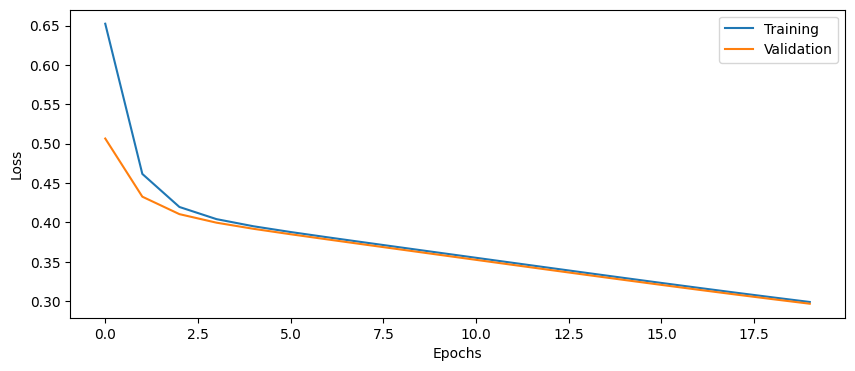

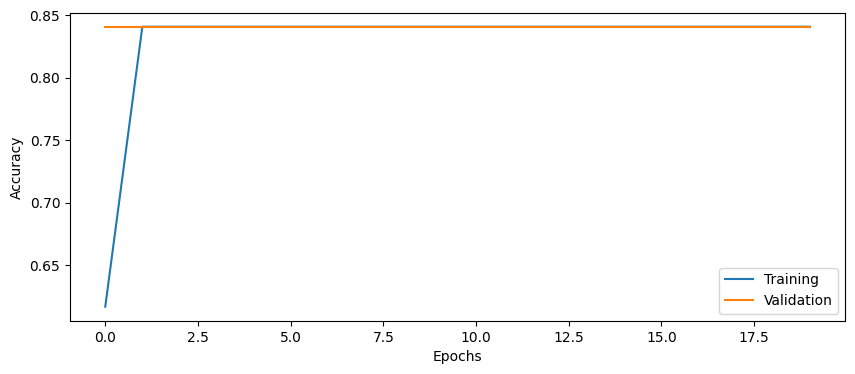

In [66]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


#### **<span style="color:green">Answer:</span>**

**Question 5:** When we add several Dense layers without specifying the activation function, keras will use no activation function. Mathematically we could remove these layers and add more nodes to the last layer that had an activation function.

**Question 6:** The weights are initialized with glorot uniform by default. The bias weights are initialized as zeros.

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [70]:
from sklearn.utils import class_weight

# Calculate class weights
weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Ytrain), y = Ytrain)

# Print the class weights
print(f"Weights for class 0: {round(weights[0],4)}")
print(f"Weights for class 1: {round(weights[1],4)}")
# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: weights[0],
                 1: weights[1]}
print(class_weights)

Weights for class 0: 3.1438
Weights for class 1: 0.5946
{0: 3.143815166155329, 1: 0.5945603169239525}


### 2 layers, 20 nodes, class weights

In [71]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92

# Build and train model
model2 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes=20)

history2 = model2.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), class_weight = class_weights, batch_size = batch_size, epochs = epochs)

Epoch 1/20
54/54 [==============================] - 1s 10ms/step - loss: 0.7333 - accuracy: 0.1590 - val_loss: 0.8168 - val_accuracy: 0.1594
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.1594 - val_loss: 0.7260 - val_accuracy: 0.1607
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.6698 - accuracy: 0.3156 - val_loss: 0.6822 - val_accuracy: 0.8324
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.6542 - accuracy: 0.8660 - val_loss: 0.6557 - val_accuracy: 0.8809
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.6388 - accuracy: 0.8854 - val_loss: 0.6356 - val_accuracy: 0.8878
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6230 - accuracy: 0.8896 - val_loss: 0.6179 - val_accuracy: 0.8896
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6065 - accuracy: 0.8912 - val_loss: 0.6003 - val_accuracy: 0.8915
Epoch 8/20
54/54 [=

In [72]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.3772 - accuracy: 0.8849
Test loss: 0.3772
Test accuracy: 0.8849


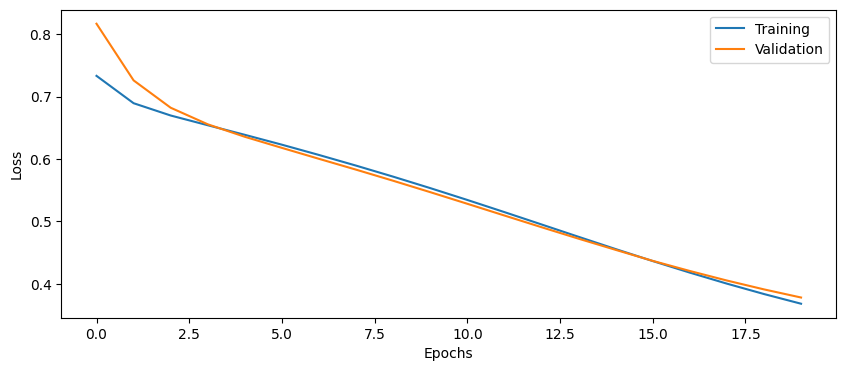

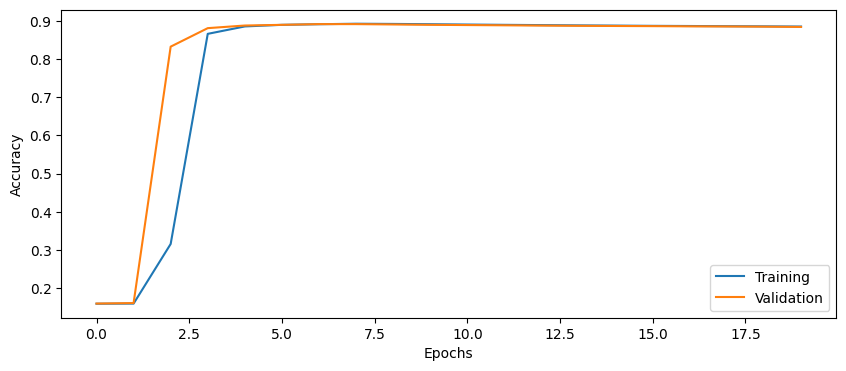

In [73]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 11: What limits how large the batch size can be?

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

#### **<span style="color:green">Answer:</span>**



* Question 7:
In case we have a large data set, all of the data might not be able to fit in CPU, so without batch size the training would crash. With batch size, we update the weights after the model has seen batch size number of observations, which can speed up training.

* Question 10: 
The number of observations in training data is 534895. 
    * With batch size of 100, we will update the weights 534895/100 = 5349 times per epoch.
    
    * With batch size of 1000, we will update the weights 534895/1000 = 535 times per epoch..
        
    * With batch size of 10000, we will update the weights 534895/10000 = 54 times per epoch.

* Question 11: 
We run on CPU, so we are limited by the memory of the CPU. So the size of the data with batch size can not be larger than the memory.

* Question 12:
With low batch size, we should have small learning rate since the gradient is more uncertain. With large batch size we should increase learning rate, otherwise training will take longer.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

### 4 layers, 20 nodes, class weights

In [78]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92

# Build and train model
model3 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 20, learning_rate = 0.1)

history3 = model3.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), class_weight = class_weights, batch_size = batch_size, epochs = epochs)

Epoch 1/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6938 - accuracy: 0.3616 - val_loss: 0.6968 - val_accuracy: 0.1620
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5313 - val_loss: 0.6853 - val_accuracy: 0.8406
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.6482 - val_loss: 0.6855 - val_accuracy: 0.8412
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.7844 - val_loss: 0.6829 - val_accuracy: 0.8409
Epoch 5/20
54/54 [==============================] - 0s 8ms/step - loss: 0.6886 - accuracy: 0.8454 - val_loss: 0.6928 - val_accuracy: 0.3962
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.6870 - accuracy: 0.8611 - val_loss: 0.6874 - val_accuracy: 0.8808
Epoch 7/20
54/54 [==============================] - 1s 15ms/step - loss: 0.6848 - accuracy: 0.8854 - val_loss: 0.6825 - val_accuracy: 0.8913
Epoch 8/20
54/54 [

In [79]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2684 - accuracy: 0.8818
Test loss: 0.2684
Test accuracy: 0.8818


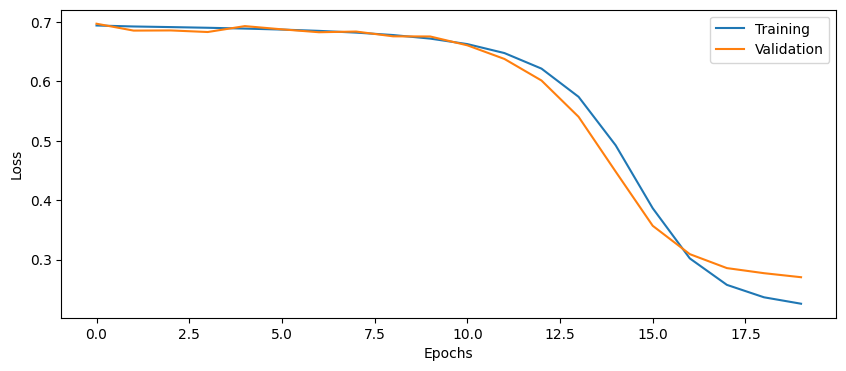

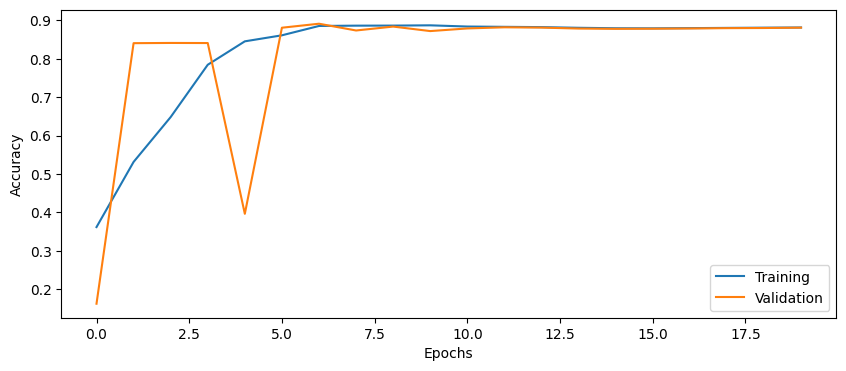

In [80]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [81]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92

# Build and train model
model4 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 50, learning_rate = 0.1)

history4 = model4.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), class_weight = class_weights, batch_size = batch_size, epochs = epochs)


Epoch 1/20
54/54 [==============================] - 1s 12ms/step - loss: 0.6507 - accuracy: 0.7322 - val_loss: 0.5382 - val_accuracy: 0.8764
Epoch 2/20
54/54 [==============================] - 0s 9ms/step - loss: 0.4211 - accuracy: 0.8803 - val_loss: 0.3481 - val_accuracy: 0.8802
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2801 - accuracy: 0.8823 - val_loss: 0.2889 - val_accuracy: 0.8826
Epoch 4/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2363 - accuracy: 0.8852 - val_loss: 0.2735 - val_accuracy: 0.8862
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2209 - accuracy: 0.8888 - val_loss: 0.2648 - val_accuracy: 0.8901
Epoch 6/20
54/54 [==============================] - 1s 9ms/step - loss: 0.2128 - accuracy: 0.8923 - val_loss: 0.2593 - val_accuracy: 0.8927
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2073 - accuracy: 0.8946 - val_loss: 0.2548 - val_accuracy: 0.8948
Epoch 8/20
54/5

In [82]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 5s 1ms/step - loss: 0.2286 - accuracy: 0.9053
Test loss: 0.2286
Test accuracy: 0.9053


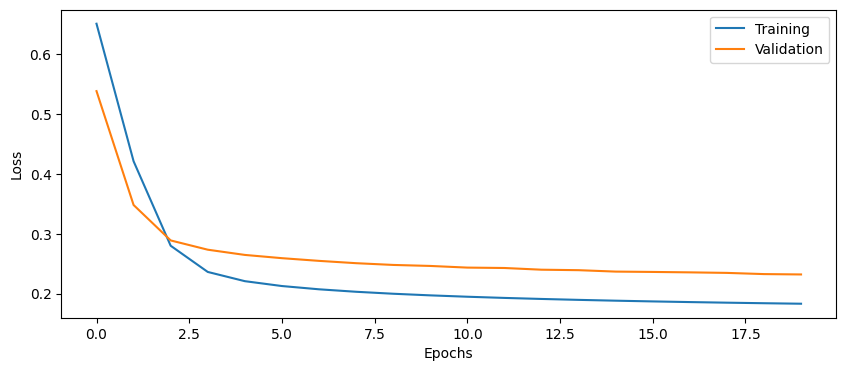

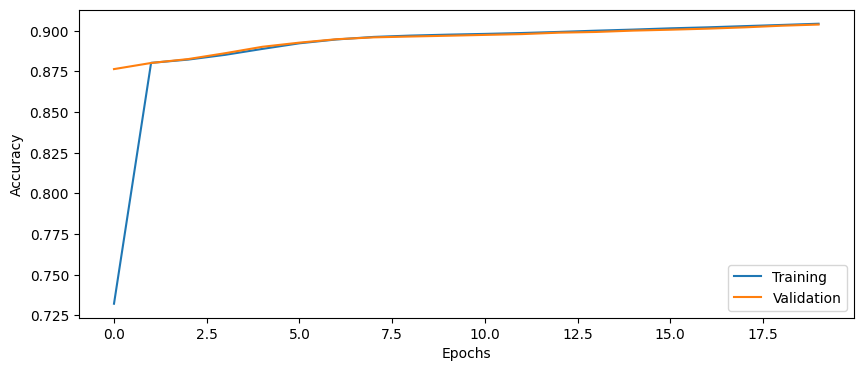

In [83]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [87]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = 92

# Build and train model
model5 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 50, learning_rate = 0.1)

history5 = model5.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), class_weight = class_weights, batch_size = batch_size, epochs = epochs)


Epoch 1/20
54/54 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6868 - val_accuracy: 0.8417
Epoch 2/20
54/54 [==============================] - 1s 14ms/step - loss: 0.6919 - accuracy: 0.5959 - val_loss: 0.6861 - val_accuracy: 0.8440
Epoch 3/20
54/54 [==============================] - 1s 14ms/step - loss: 0.6907 - accuracy: 0.6605 - val_loss: 0.6826 - val_accuracy: 0.8430
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.6892 - accuracy: 0.6937 - val_loss: 0.6847 - val_accuracy: 0.8560
Epoch 5/20
54/54 [==============================] - 1s 18ms/step - loss: 0.6873 - accuracy: 0.7783 - val_loss: 0.6911 - val_accuracy: 0.8632
Epoch 6/20
54/54 [==============================] - 1s 18ms/step - loss: 0.6848 - accuracy: 0.8162 - val_loss: 0.6856 - val_accuracy: 0.8833
Epoch 7/20
54/54 [==============================] - 1s 18ms/step - loss: 0.6812 - accuracy: 0.8853 - val_loss: 0.6775 - val_accuracy: 0.8909
Epoch 8/20
54

In [86]:
# To answer question 13
model1.summary()
model5.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 20)                1860      
                                                                 
 dense_49 (Dense)            (None, 20)                420       
                                                                 
 dense_50 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 50)                4650      
                                                                 
 dense_81 (Dense)           

#### **<span style="color:green">Answer:</span>**

**Question 13:** The network with 2 Dense layers and 20 nodes per layer have 2301 trainable parameters. The network with 4 Dense layers with 50 nodes each have 12351 trainable parameters.

In [88]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 4s 1ms/step - loss: 0.2499 - accuracy: 0.8928
Test loss: 0.2499
Test accuracy: 0.8928


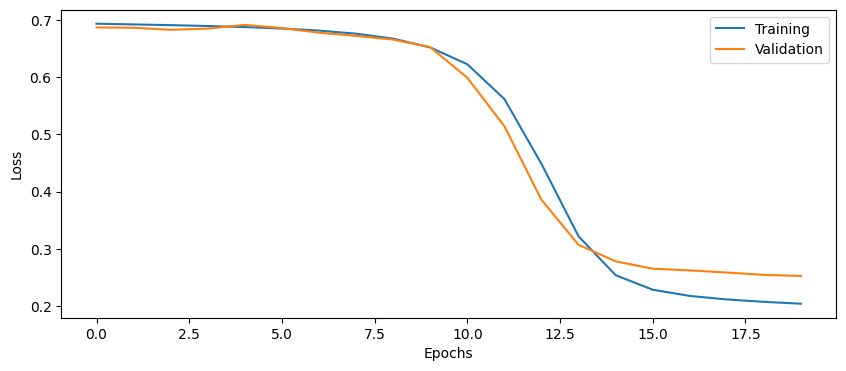

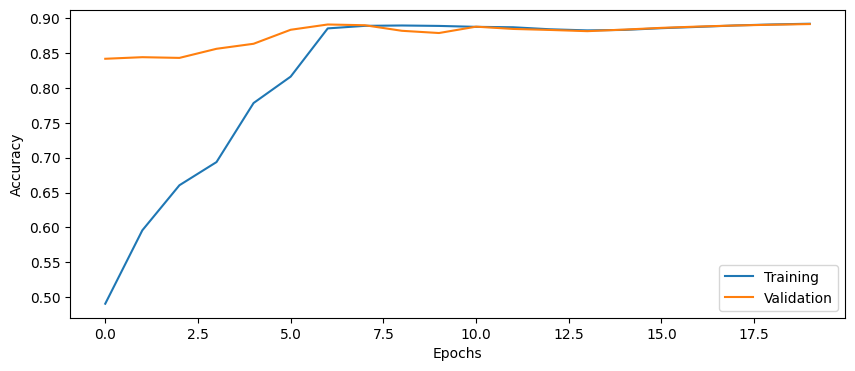

In [89]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

### 2 layers, 20 nodes, class weights, batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = ?

# Build and train model
model6 = 

history6 = 

In [ ]:
# Evaluate model on test data
score = 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

In [ ]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = ?

# Build and train model
model7 = 

history7 = 

In [ ]:
# Evaluate model on test data
score = 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

In [ ]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = ?

# Build and train model
model8 = 

history8 = 

In [ ]:
# Evaluate model on test data
score = 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

In [ ]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

Question 16: How does the test accuracy change when adding dropout?

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = ?

# Build and train model
model9 = 

history9 = 

In [ ]:
# Evaluate model on test data
score = 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

In [ ]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

In [ ]:
# Find your best configuration for the DNN

# Build and train DNN
model10 = 

history10 = 


In [ ]:
# Evaluate DNN on test data
score = 

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

In [ ]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [ ]:
# Your best training parameters


# Build and train model
model11 = 

history11 = 

In [ ]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = 
                       
print('Test accuracy: %.4f' % score[1])

In [ ]:
# Run the testing 100 times, and save the accuracies in an array

    
# Calculate and print mean and std of accuracies



# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation

# Loop over cross validation folds
    
    # Calculate class weights for current split
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    
    # Fit the model with training set and class weights for this fold
    
    # Evaluate the model using the test set for this fold
    
    # Save the test accuracy in an array

# Calculate and print mean and std of accuracies



# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

## Report

Send in this jupyter notebook, with answers to all questions.